# 분석보고서

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum as spark_sum

spark = SparkSession.builder.appName("MobEfficiency").getOrCreate()

## 데이터 불러오기

In [2]:
mobs = spark.read.csv('../learning_spark_data/minecraft/Mobs.csv', header=True, inferSchema=True)
food = spark.read.csv('../learning_spark_data/minecraft/Food.csv', header=True, inferSchema=True)
mob_food = spark.read.csv('../learning_spark_data/minecraft/MobFoodDrops.csv', header=True, inferSchema=True)

### 데이터 전처리

In [3]:
# 필요없는 데이터 컬럼 drop
mobs = mobs.drop("behaviorTypes", "spawnBehavior", "debutDate", "minecraftVersion", "reproductiveRequirement")
food = food.drop("debutDate", "minecraftVersion")

In [4]:
# NULL 처리 및 캐스팅
mobs = mobs.withColumn("healthPoints", col("healthPoints").cast("double"))
mobs = mobs.withColumn("maxDamage", when(col("maxDamage").isNull(), 0).otherwise(col("maxDamage")).cast("double"))
mobs = mobs.withColumn("difficultyScore", col("healthPoints") + col("maxDamage") * 2)

food = food.withColumn("hunger", col("hunger").cast("double"))  # 드롭 가치 = hunger

In [5]:
# NULL 값 처리 및 데이터 확인
print(mobs.show(10))
print(food.show(10))
print(mob_food.show(10))

+---+--------------+------------+---------+---------------+
| ID|          name|healthPoints|maxDamage|difficultyScore|
+---+--------------+------------+---------+---------------+
|  1|   sniffer_egg|         0.0|      0.0|            0.0|
|  2|    turtle_egg|         0.0|      0.0|            0.0|
|  3|           bat|         6.0|      0.0|            6.0|
|  4|         blaze|        20.0|      6.0|           32.0|
|  5|       chicken|         4.0|      0.0|            4.0|
|  6|       dolphin|        10.0|      3.0|           16.0|
|  7|     endermite|         8.0|      2.0|           12.0|
|  8|      guardian|        30.0|      6.0|           42.0|
|  9|guardian_elder|        80.0|      8.0|           96.0|
| 10|       phantom|        20.0|      2.0|           24.0|
+---+--------------+------------+---------+---------------+
only showing top 10 rows

None
+---+---------------+------+------+
| ID|           name|  type|hunger|
+---+---------------+------+------+
| 13| cooked_chicken|

## 몹과 음식 간 드롭 관계 Join

In [6]:
# mobID → 몹 ID, foodID → 음식 ID로 연결

# mob_food + food 조인 (foodID 기준)
mob_food_value = mob_food.join(food, mob_food["foodID"] == food["ID"], how="left") \
                         .select(mob_food["mobID"], food["hunger"])

# 몹별 총 음식 드롭 가치 합산
mob_drop_value = mob_food_value.groupBy("mobID").agg(
    spark_sum("hunger").alias("totalDropValue")
)

mob_drop_value.show(10)

+-----+--------------+
|mobID|totalDropValue|
+-----+--------------+
|   53|           3.0|
|   78|           8.0|
|   34|           3.0|
|   28|           2.0|
|   76|           8.0|
|   26|           2.0|
|   22|           3.0|
|   52|           4.0|
|    6|           2.0|
|   54|           3.0|
+-----+--------------+
only showing top 10 rows



<Mob과 Food 데이터 조인>
- mob_food.join(food, mob_food["foodID"] == food["ID"], how="left")
- 몹이 어떤 음식을 드롭하는지, 해당 음식의 회복량(hunger)은 얼마인지 연결

<필요한 컬럼 선택>
- .select(mob_food["mobID"], food["hunger"])
- 몹 ID와 음식 가치만 추출

<몹별 음식 가치 합산>
- .groupBy("mobID").agg(sum("hunger").alias("totalDropValue"))
- 각 몹이 드롭하는 모든 음식의 회복량을 합산 → totalDropValue로 저장

**결과 해석**
- mobID 별로 해당 몹이 사냥 시 떨어뜨리는 음식의 총 회복량을 수치화함
- totalDropValue 값이 클수록, 사냥 시 음식 회복 아이템 획득 기대값이 높음
- totalDropValue = 0인 경우는 음식 드롭이 없거나, hunger=0인 음식을 드롭하는 경우

### 시각화

In [7]:
# PySpark DataFrame을 Pandas로 변환
mob_drop_pd = mob_drop_value.toPandas()

In [8]:
# mobs에서 ID, name만 추출
mob_names = mobs.select("ID", "name")

# ID 기준으로 join
mob_drop_named = mob_drop_value.join(mob_names, mob_drop_value["mobID"] == mob_names["ID"], how="left") \
                                .select("name", "totalDropValue")

# Pandas로 변환
mob_drop_pd = mob_drop_named.toPandas()

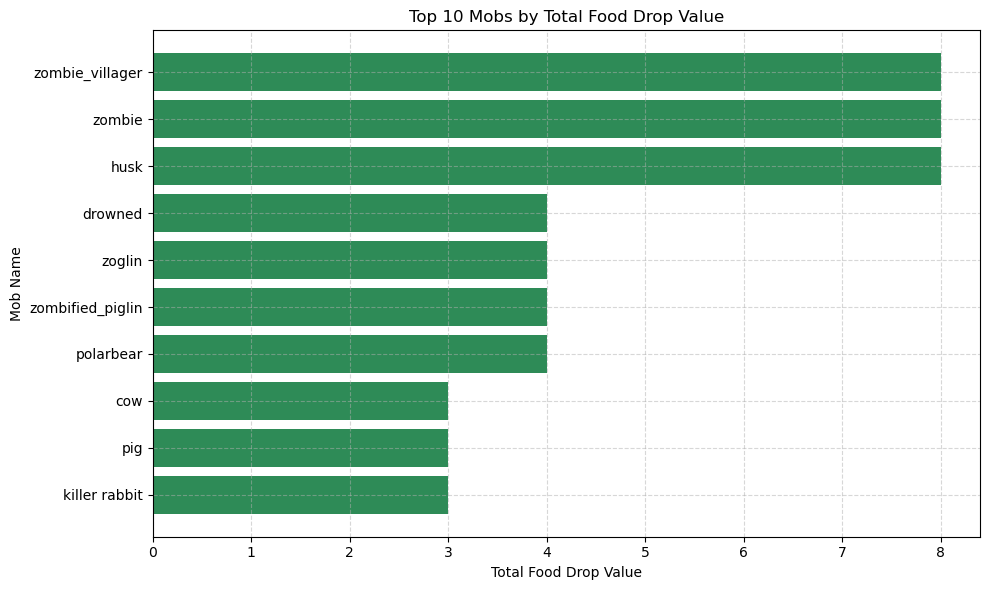

In [9]:
import matplotlib.pyplot as plt

# 값이 큰 순서로 정렬 (TOP 10)
top_mobs = mob_drop_pd.sort_values("totalDropValue", ascending=False).head(10)

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.barh(top_mobs["name"], top_mobs["totalDropValue"], color='seagreen')
plt.xlabel("Total Food Drop Value")
plt.ylabel("Mob Name")
plt.title("Top 10 Mobs by Total Food Drop Value")
plt.gca().invert_yaxis()  # 값 큰 것 위로
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<그래프 설명>
- X축: 해당 몹이 드롭하는 음식의 총 회복량 (Total Food Drop Value)
    - 드롭되는 음식의 hunger 값(회복력)을 합산한 것
- Y축: 몹 이름 (Mob Name)
- 막대길이: 해당 몹을 사냥했을 때 기대할 수 있는 음식 아이템의 총 가치

<주요 해석 포인트>
- 1위 ~ 3위:
    - zombie_villager, zombie, husk
    - 모두 Total Drop Value = 8로 가장 높음
    - 동일한 음식을 드롭하거나, 같은 종류의 음식 드롭이 중첩되는 구조로 추정됨

- 중위권:
    - drowned, zoglin, zombified_piglin, polarbear
    - 4로 동일한 드롭 가치를 가짐
    - 보스급은 아니지만 식량 획득에 유용한 몹으로 해석 가능

- 하위권 (10위권 이내):
    - cow, pig, killer rabbit → 3
    - 전통적인 음식 드롭 몹 (가축류)임에도 불구하고 상대적으로 낮은 총 가치
    - 아마도 하나의 음식만 드롭하거나, hunger 값이 낮은 음식일 가능성
 
**결론 및 활용 제안**
- 좀비 계열 몹이 의외로 높은 음식 드롭 가치를 보유함 → 효율적인 사냥 대상
    - 단순히 가축이 아니라, 적대적 몹들 (zombie 계열)도 음식 드롭 측면에서 효율적일 수 있음
- 이 데이터를 바탕으로 사냥 가성비(드롭 가치 / 난이도) 를 추가 분석하면 전략 수립 가능



## mobs + drop 가치 join → 가성비 계산

In [18]:
from pyspark.sql.functions import col, when, format_number

# mobs.ID ↔ mob_drop_value.mobID 연결
mob_efficiency = mobs.join(mob_drop_value, mobs["ID"] == mob_drop_value["mobID"], how="left")

# NULL 처리: 드롭 없으면 0
mob_efficiency = mob_efficiency.withColumn(
    "totalDropValue",
    when(col("totalDropValue").isNull(), 0).otherwise(col("totalDropValue"))
)

# 가성비 계산: 드롭 가치 / (사냥 난이도 + 1)
mob_efficiency = mob_efficiency.withColumn(
    "efficiencyScore",
    col("totalDropValue") / (col("difficultyScore") + 1)
)

# totalDropValue가 0인 행 제거
mob_efficiency = mob_efficiency.filter(col("totalDropValue") > 0)

# 소수점 둘째자리로 포맷 (출력용)
mob_efficiency = mob_efficiency.withColumn(
    "efficiencyScore_2dp", format_number("efficiencyScore", 2)
)

# 출력
mob_efficiency.select(
    "name", "healthPoints", "maxDamage", "difficultyScore", "totalDropValue", "efficiencyScore_2dp"
).orderBy(col("efficiencyScore").desc()).show(30, truncate=False)

+----------------+------------+---------+---------------+--------------+-------------------+
|name            |healthPoints|maxDamage|difficultyScore|totalDropValue|efficiencyScore_2dp|
+----------------+------------+---------+---------------+--------------+-------------------+
|salmon          |3.0         |0.0      |3.0            |2.0           |0.50               |
|cod             |3.0         |0.0      |3.0            |2.0           |0.50               |
|chicken         |4.0         |0.0      |4.0            |2.0           |0.40               |
|zombie_villager |20.0        |3.0      |26.0           |8.0           |0.30               |
|husk            |20.0        |3.0      |26.0           |8.0           |0.30               |
|zombie          |20.0        |3.0      |26.0           |8.0           |0.30               |
|mooshroom       |10.0        |0.0      |10.0           |3.0           |0.27               |
|pig             |10.0        |0.0      |10.0           |3.0          

## 결과 출력 (가성비 높은 몹 상위 10)

In [12]:
from pyspark.sql.functions import round, col

mob_efficiency.select(
    "name",
    "healthPoints",
    "maxDamage",
    "difficultyScore",
    "totalDropValue",
    round("efficiencyScore", 2).alias("efficiencyScore")
).orderBy(col("efficiencyScore").desc()) \
 .show(10, truncate=False)

+---------------+------------+---------+---------------+--------------+---------------+
|name           |healthPoints|maxDamage|difficultyScore|totalDropValue|efficiencyScore|
+---------------+------------+---------+---------------+--------------+---------------+
|cod            |3.0         |0.0      |3.0            |2.0           |0.5            |
|salmon         |3.0         |0.0      |3.0            |2.0           |0.5            |
|chicken        |4.0         |0.0      |4.0            |2.0           |0.4            |
|husk           |20.0        |3.0      |26.0           |8.0           |0.3            |
|zombie         |20.0        |3.0      |26.0           |8.0           |0.3            |
|zombie_villager|20.0        |3.0      |26.0           |8.0           |0.3            |
|cow            |10.0        |0.0      |10.0           |3.0           |0.27           |
|mooshroom      |10.0        |0.0      |10.0           |3.0           |0.27           |
|pig            |10.0        |0.